Deep Learning Sentiment Analysis: Stacked BiLSTM

## Overview
This notebook implements a Deep Learning approach to Sentiment Analysis on the IMDB dataset. This model utilizes **Word Embeddings** and **Recurrent Neural Networks (RNNs)** to capture semantic meaning and sequential dependencies in text.

## Technical Architecture
* **Embedding Layer:** Pre-trained **Word2Vec (Google News 300d)** vectors to initialize the model with semantic knowledge.
* **Model:** Stacked Bidirectional LSTM (BiLSTM) with Global Max Pooling.
* **Optimization:** Adam Optimizer with CrossEntropyLoss.

In [1]:
#!pip install gensim
#!pip install datasets
import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset
from torch.utils.data import DataLoader , Dataset

import pandas as pd

import gensim.downloader as api
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device :{device}")

using device :cpu


##  Data Loading & Transfer Learning
Leveraging **Transfer Learning** by loading pre-trained word vectors from Google News (300-dimensional). This allows the model to understand that "good" and "great" are semantically similar before it even sees the training data.

The IMDB dataset is split into:
* **Train:** Used for training the weights.
* **Development (Dev):** Used for hyperparameter tuning and early stopping.
* **Test:** Held out for final evaluation.

In [5]:
#word2vec google-news-300
w2v = api.load("word2vec-google-news-300")
#imdb dataset
dataset = load_dataset("imdb")

train_text_full = list(dataset['train']['text'])
train_label_full = list(dataset['train']['label'])
test_text = list(dataset['test']['text'])
test_label = list(dataset['test']['label'])

train_text , dev_text , train_labels , dev_labels = train_test_split( train_text_full , train_label_full , test_size = 0.2 , random_state = 42)

print(f"Training data size: {len(train_text)}")
print(f"Development data size: {len(dev_text)}")

Training data size: 20000
Development data size: 5000


## Building the Embedding Matrix
Since neural networks require numerical input,  mapping every unique word in the training vocabulary to its corresponding 300-dimensional vector from Word2Vec.

* **Unknown Words (`<UNK>`):** Words not found in Word2Vec are initialized with a random normal distribution.
* **Padding (`<PAD>`):** Used to ensure all sentences in a batch have the same length (mapped to a vector of zeros).

In [7]:
#συνάρτηση για δημιουργία πίνακα με τα word embeddings όλων των λέξεων που βλέπουμε στα training data
def create_embedding_matrix(word_vectors , texts , min_freq = 1):
    word_counts = Counter()
    for text in texts :
        word_counts.update(text.lower().split())

    word2index = {'<PAD>' : 0 , '<UNK>' : 1}
    weights = [np.zeros(300) , np.random.normal(scale = 0.6 , size = (300,))]
    index = 2
    for word , count in word_counts.items():
        if ((count >= min_freq) and (word in word_vectors)):
            word2index[word] = index
            weights.append(word_vectors[word])
            index += 1

    return word2index , np.array(weights)

word2index , embeddings_matrix = create_embedding_matrix(w2v , train_text)
embeddings_tensor = torch.FloatTensor(embeddings_matrix)

print(f"Vocabulary size : {len(word2index)}")
print(f"Embeddings matrix dimentions : {embeddings_tensor.shape}")

Vocabulary size : 41773
Embeddings matrix dimentions : torch.Size([41773, 300])


##  Tokenization & Data Loaders
Implementing a custom tokenizer to convert raw text strings into sequences of integers (indices).

* **Truncation/Padding:** All reviews are fixed to a length of **250 tokens**. Shorter reviews are padded with zeros.
* **PyTorch DataLoaders:** Wrapping the tensors in a custom `Dataset` class to handle batching (Batch Size = 64) and shuffling during training.

In [9]:
def tokenize(text_list , word2index , max_length = 250):
    data = []
    unk = word2index['<UNK>']
    for text in text_list:
        indices = [word2index.get(w, unk) for w in text.lower().split()][:max_length]
        if len(indices) < max_length: indices += [0]*(max_length-len(indices))
        data.append(indices)

    return torch.tensor(data, dtype=torch.long)

train_text_tensor = tokenize(train_text , word2index)
dev_text_tensor = tokenize(dev_text , word2index)
train_labels_tensor = torch.tensor(train_labels , dtype=torch.float32)
dev_labels_tensor = torch.tensor(dev_labels , dtype=torch.float32)


class IMDB(Dataset):
    def __init__(self , x , y): self.x , self.y = x , y
    def __len__(self):return len(self.x)
    def __getitem__(self , i): return self.x[i] , self.y[i]

train_loader = DataLoader(IMDB(train_text_tensor,train_labels_tensor) , batch_size = 64 , shuffle = True)
dev_loader = DataLoader(IMDB(dev_text_tensor,dev_labels_tensor) , batch_size = 64)

## Model Architecture: Stacked BiLSTM
Designing a custom Recurrent Neural Network using PyTorch.

### Key Components:
1.  **Frozen Embedding Layer:** Weights are initialized from Word2Vec and **frozen** (not updated) to prevent overfitting on the small IMDB dataset.
2.  **Bidirectional LSTM:** The network reads text both forwards and backwards, allowing it to capture context from both past and future words. We stack **2 layers** for abstract feature extraction.
3.  **Global Max Pooling:** Instead of using just the final hidden state, we take the maximum activation across the time dimension to isolate the most salient features (e.g., the strongest "negative" signal in the sentence).
4.  **Dropout (0.25):** Applied to hidden layers to prevent overfitting.

In [11]:
class stackedBiRNN(nn.Module):
    def __init__(self , weights , hidden_dim , n_layers , dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=True, padding_idx=0)
        self.lstm = nn.LSTM(300, hidden_dim, num_layers=n_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, 2)

    def forward(self , x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        pooled = torch.max(out, dim=1)[0]
        return self.fc(self.dropout(pooled))

myModel = stackedBiRNN(embeddings_tensor , hidden_dim = 64 , n_layers = 2 , dropout = 0.25).to(device)
myOptimizer = optim.Adam(myModel.parameters() , lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(myModel)

stackedBiRNN(
  (embedding): Embedding(41773, 300, padding_idx=0)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


## Training & Validation
Training the model for 10 epochs to observe the learning curve.

* **Loss Function:** `CrossEntropyLoss` (because of binary classification).
* **Optimizer:** `Adam` optimizer with a learning rate of 0.001.

**Goal:** We look to identify the optimal number of epochs before the model starts overfitting.

In [15]:
train_losses = []
dev_losses = []
epochs = 10

print("starting training...")

for epoch in range(epochs):
    myModel.train()
    train_loss = 0
    for texts , labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        myOptimizer.zero_grad()
        outputs = myModel(texts)
        loss = criterion(outputs , labels.long())
        loss.backward()
        myOptimizer.step()
        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    myModel.eval()
    dev_loss = 0
    for texts , labels in dev_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = myModel(texts)
        loss = criterion(outputs , labels.long())
        dev_loss += loss.item()

    average_dev_loss = dev_loss / len(dev_loader)
    dev_losses.append(average_dev_loss)

    print(f"Epoch {epoch+1} | Train Loss: {average_train_loss:.4f} | Dev Loss: {average_dev_loss:.4f}")

starting training...
Epoch 1 | Train Loss: 0.3743 | Dev Loss: 0.3781
Epoch 2 | Train Loss: 0.3476 | Dev Loss: 0.3616
Epoch 3 | Train Loss: 0.3227 | Dev Loss: 0.3333
Epoch 4 | Train Loss: 0.3011 | Dev Loss: 0.3392
Epoch 5 | Train Loss: 0.2792 | Dev Loss: 0.3325
Epoch 6 | Train Loss: 0.2570 | Dev Loss: 0.3449
Epoch 7 | Train Loss: 0.2333 | Dev Loss: 0.3423
Epoch 8 | Train Loss: 0.2116 | Dev Loss: 0.3687
Epoch 9 | Train Loss: 0.1872 | Dev Loss: 0.3869
Epoch 10 | Train Loss: 0.1587 | Dev Loss: 0.4349


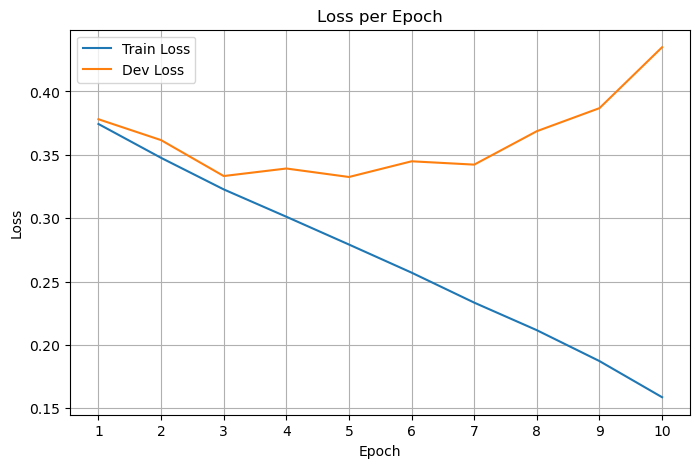

In [17]:
epochs_range = range(1, len(dev_losses)+1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range ,train_losses, label='Train Loss')
plt.plot(epochs_range , dev_losses, label='Dev Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs_range)
plt.legend()
plt.grid()
plt.show()

## Final Evaluation
Based on the validation curve, we identify the **Best Epoch** count. We then:
1.  **Retrain** a fresh instance of the model on the **Full Training Set** (Train + Dev combined) for exactly that many epochs.
2.  **Evaluate** on the held-out Test Set.

The final Classification Report below details the Precision, Recall, and F1-Score for both positive and negative classes.

In [19]:
min_loss = min(dev_losses)
best_epoch = dev_losses.index(min_loss) + 1

final_model = stackedBiRNN(embeddings_tensor , hidden_dim = 64 , n_layers = 2 , dropout = 0.25).to(device)
final_optimizer = optim.Adam(final_model.parameters() , lr = 0.001)
criterion = nn.CrossEntropyLoss()

final_train_text_tensor = tokenize(train_text_full , word2index)
final_train_labels_tensor = torch.tensor(train_label_full , dtype=torch.float32)
final_train_loader = DataLoader(IMDB(final_train_text_tensor , final_train_labels_tensor ) , batch_size=64 , shuffle = True)

print("finally training in all data...")
for epoch in range(best_epoch):
    final_model.train()
    for texts , labels in final_train_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(texts)
        loss = criterion(outputs , labels.long())
        loss.backward()
        final_optimizer.step()

finally training in all data...


In [29]:
test_text_tensor = tokenize( test_text, word2index)
test_labels_tensor = torch.tensor( test_label , dtype=torch.float32)
test_loader = DataLoader(IMDB(test_text_tensor , test_labels_tensor)  , batch_size=64)

predictions = []
answears = []
final_model.eval()

with torch.no_grad():
    for texts , labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = final_model(texts)
        _, predicted = torch.max(outputs, dim=1)
        predictions.extend(predicted.cpu().numpy())
        answears.extend(labels.cpu().numpy())

report = classification_report(
        predictions, 
        answears, 
        target_names=['Negative', 'Positive'], 
        digits=4 
    )
print(report)

              precision    recall  f1-score   support

    Negative     0.8113    0.8962    0.8516     11315
    Positive     0.9061    0.8276    0.8651     13685

    accuracy                         0.8587     25000
   macro avg     0.8587    0.8619    0.8584     25000
weighted avg     0.8632    0.8587    0.8590     25000

